In [1]:
Reference:https://www.kaggle.com/code/paramarthasengupta/microsoft-stocks-price-prediction/notebook

!pip install pmdarima
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
#rom fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")
df=pd.read_csv("/content/drive/MyDrive/Microsoft_Stock.csv")

Mounted at /content/drive


In [3]:
print(df.shape)
print(df.isnull().sum())
print(df.head)

(1511, 6)
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
<bound method NDFrame.head of                     Date    Open    High     Low   Close    Volume
0      4/1/2015 16:00:00   40.60   40.76   40.31   40.72  36865322
1      4/2/2015 16:00:00   40.66   40.74   40.12   40.29  37487476
2      4/6/2015 16:00:00   40.34   41.78   40.18   41.55  39223692
3      4/7/2015 16:00:00   41.61   41.91   41.31   41.53  28809375
4      4/8/2015 16:00:00   41.48   41.69   41.04   41.42  24753438
...                  ...     ...     ...     ...     ...       ...
1506  3/25/2021 16:00:00  235.30  236.94  231.57  232.34  34061853
1507  3/26/2021 16:00:00  231.55  236.71  231.55  236.48  25479853
1508  3/29/2021 16:00:00  236.59  236.80  231.88  235.24  25227455
1509  3/30/2021 16:00:00  233.53  233.85  231.10  231.85  24792012
1510  3/31/2021 16:00:00  232.91  239.10  232.39  235.77  43623471

[1511 rows x 6 columns]>


Text(0.5, 1.0, 'Stock Price of Microsoft over the Years')

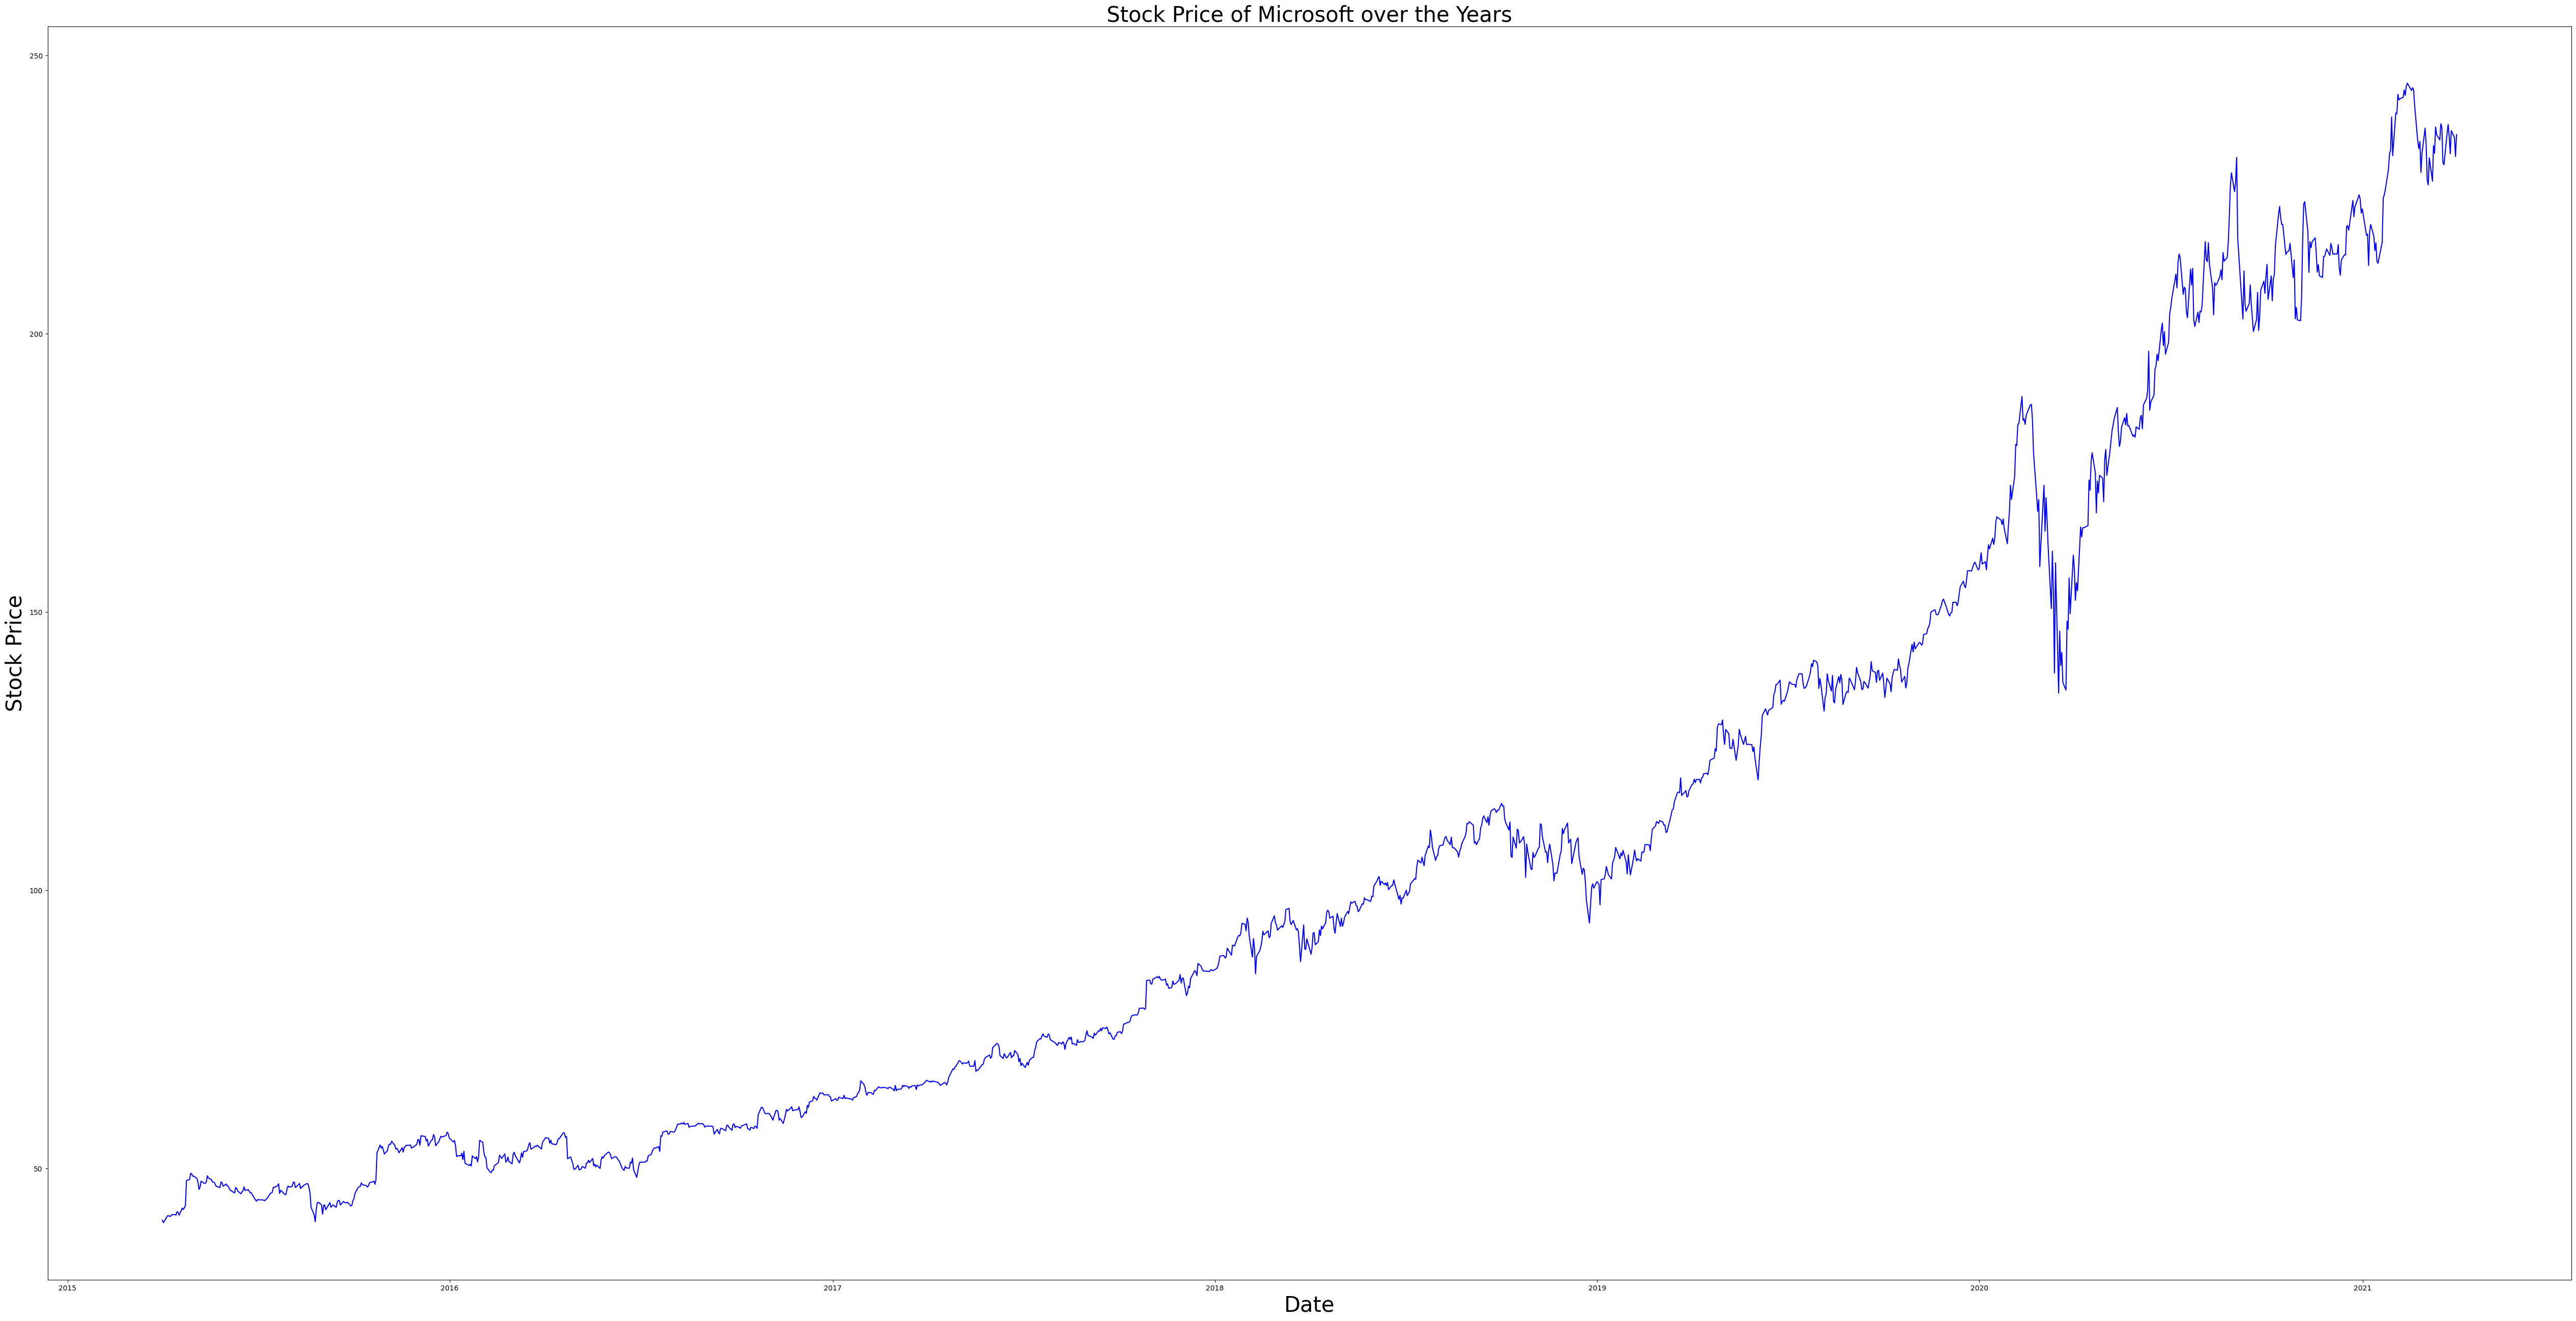

In [4]:
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(64,32))
plt.plot(df['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=30)
plt.ylabel('Stock Price',size=30)
plt.title('Stock Price of Microsoft over the Years',size=30)

In [5]:
print(df['Date'].min(), df['Date'].max(), df.Date.nunique())
print(df.isnull().sum())
print(len(df.Close.values))
closing_price=df[['Close']]


2015-04-01 16:00:00 2021-03-31 16:00:00 1511
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
1511


Shape of Training Set (1209, 1)
Shape of Validation Set (302, 1)
Epoch 1/100
147/147 - 12s - loss: 0.0027 - 12s/epoch - 81ms/step
Epoch 2/100
147/147 - 8s - loss: 1.5244e-04 - 8s/epoch - 57ms/step
Epoch 3/100
147/147 - 10s - loss: 1.6660e-04 - 10s/epoch - 71ms/step
Epoch 4/100
147/147 - 10s - loss: 1.6104e-04 - 10s/epoch - 65ms/step
Epoch 5/100
147/147 - 8s - loss: 1.7077e-04 - 8s/epoch - 55ms/step
Epoch 6/100
147/147 - 7s - loss: 1.6657e-04 - 7s/epoch - 47ms/step
Epoch 7/100
147/147 - 7s - loss: 1.2968e-04 - 7s/epoch - 50ms/step
Epoch 8/100
147/147 - 9s - loss: 1.3998e-04 - 9s/epoch - 61ms/step
Epoch 9/100
147/147 - 6s - loss: 1.4058e-04 - 6s/epoch - 43ms/step
Epoch 10/100
147/147 - 4s - loss: 1.4020e-04 - 4s/epoch - 28ms/step
Epoch 11/100
147/147 - 6s - loss: 1.4147e-04 - 6s/epoch - 38ms/step
Epoch 12/100
147/147 - 4s - loss: 1.1352e-04 - 4s/epoch - 28ms/step
Epoch 13/100
147/147 - 4s - loss: 1.5540e-04 - 4s/epoch - 28ms/step
Epoch 14/100
147/147 - 5s - loss: 1.3270e-04 - 5s/epoch - 

<ipython-input-6-915359161aa6>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


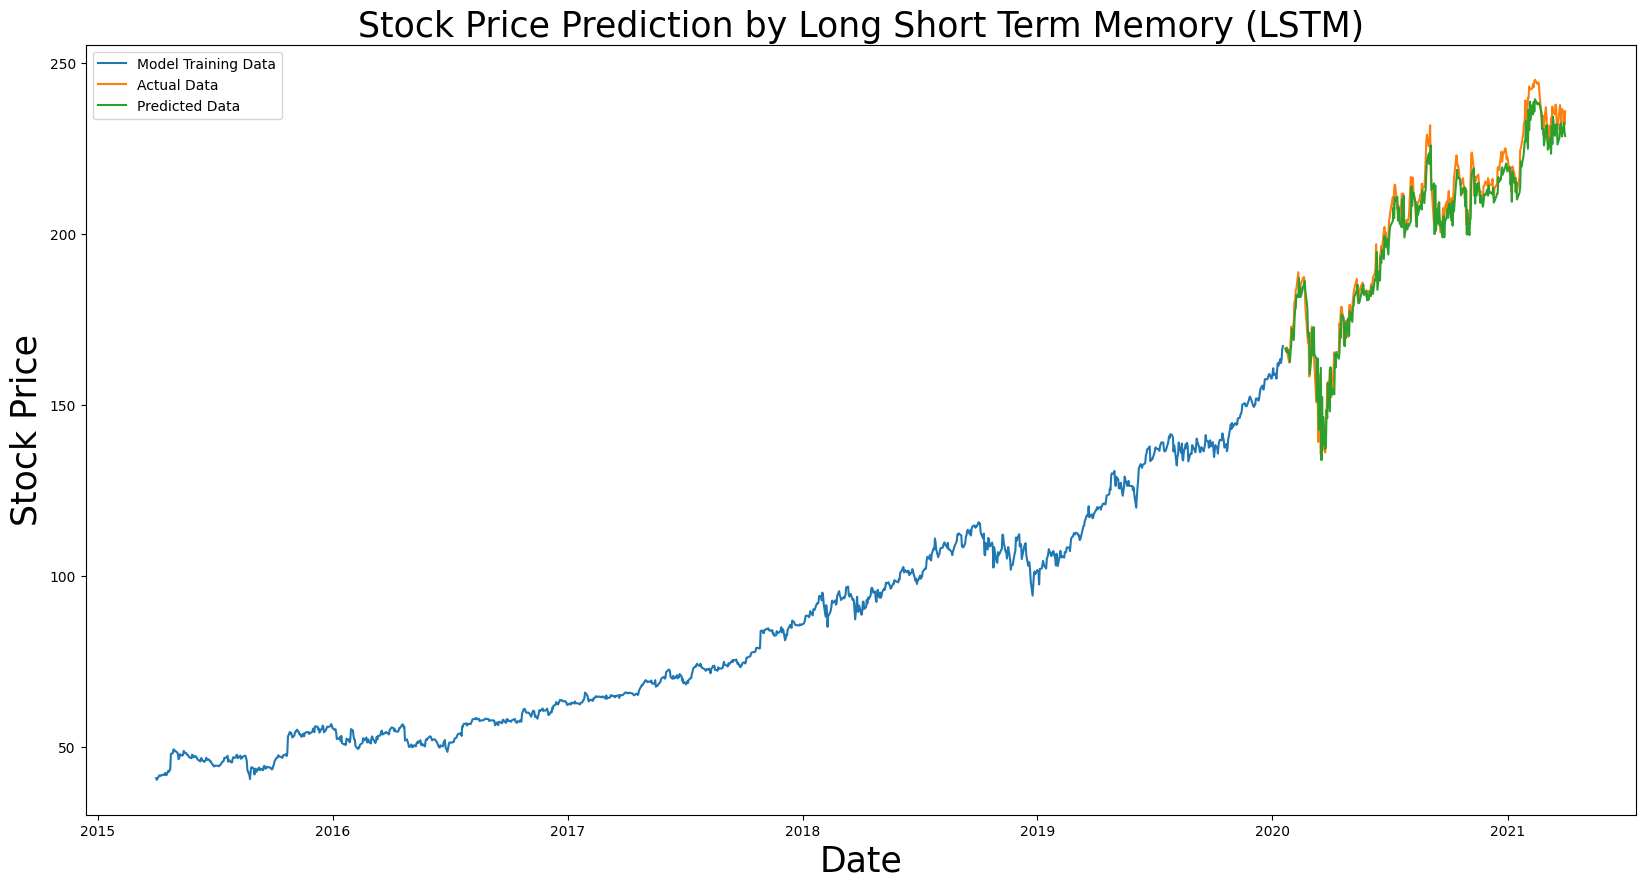

In [6]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=25)
    plt.ylabel('Stock Price',size=25)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=25)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

lstm_prediction(df)

Shape of Training Set (1209, 1)
Shape of Validation Set (302, 1)
Epoch 1/100
147/147 - 13s - loss: 0.0033 - 13s/epoch - 88ms/step
Epoch 2/100
147/147 - 5s - loss: 1.2945e-04 - 5s/epoch - 33ms/step
Epoch 3/100
147/147 - 5s - loss: 1.3310e-04 - 5s/epoch - 35ms/step
Epoch 4/100
147/147 - 4s - loss: 1.4915e-04 - 4s/epoch - 28ms/step
Epoch 5/100
147/147 - 5s - loss: 1.3539e-04 - 5s/epoch - 33ms/step
Epoch 6/100
147/147 - 5s - loss: 1.5291e-04 - 5s/epoch - 33ms/step
Epoch 7/100
147/147 - 4s - loss: 1.9055e-04 - 4s/epoch - 28ms/step
Epoch 8/100
147/147 - 5s - loss: 1.3296e-04 - 5s/epoch - 33ms/step
Epoch 9/100
147/147 - 5s - loss: 1.2425e-04 - 5s/epoch - 34ms/step
Epoch 10/100
147/147 - 5s - loss: 1.6307e-04 - 5s/epoch - 32ms/step
Epoch 11/100
147/147 - 5s - loss: 1.3641e-04 - 5s/epoch - 35ms/step
Epoch 12/100
147/147 - 6s - loss: 1.3584e-04 - 6s/epoch - 39ms/step
Epoch 13/100
147/147 - 5s - loss: 1.0975e-04 - 5s/epoch - 37ms/step
Epoch 14/100
147/147 - 6s - loss: 1.5464e-04 - 6s/epoch - 38ms

<ipython-input-7-23efd205609a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


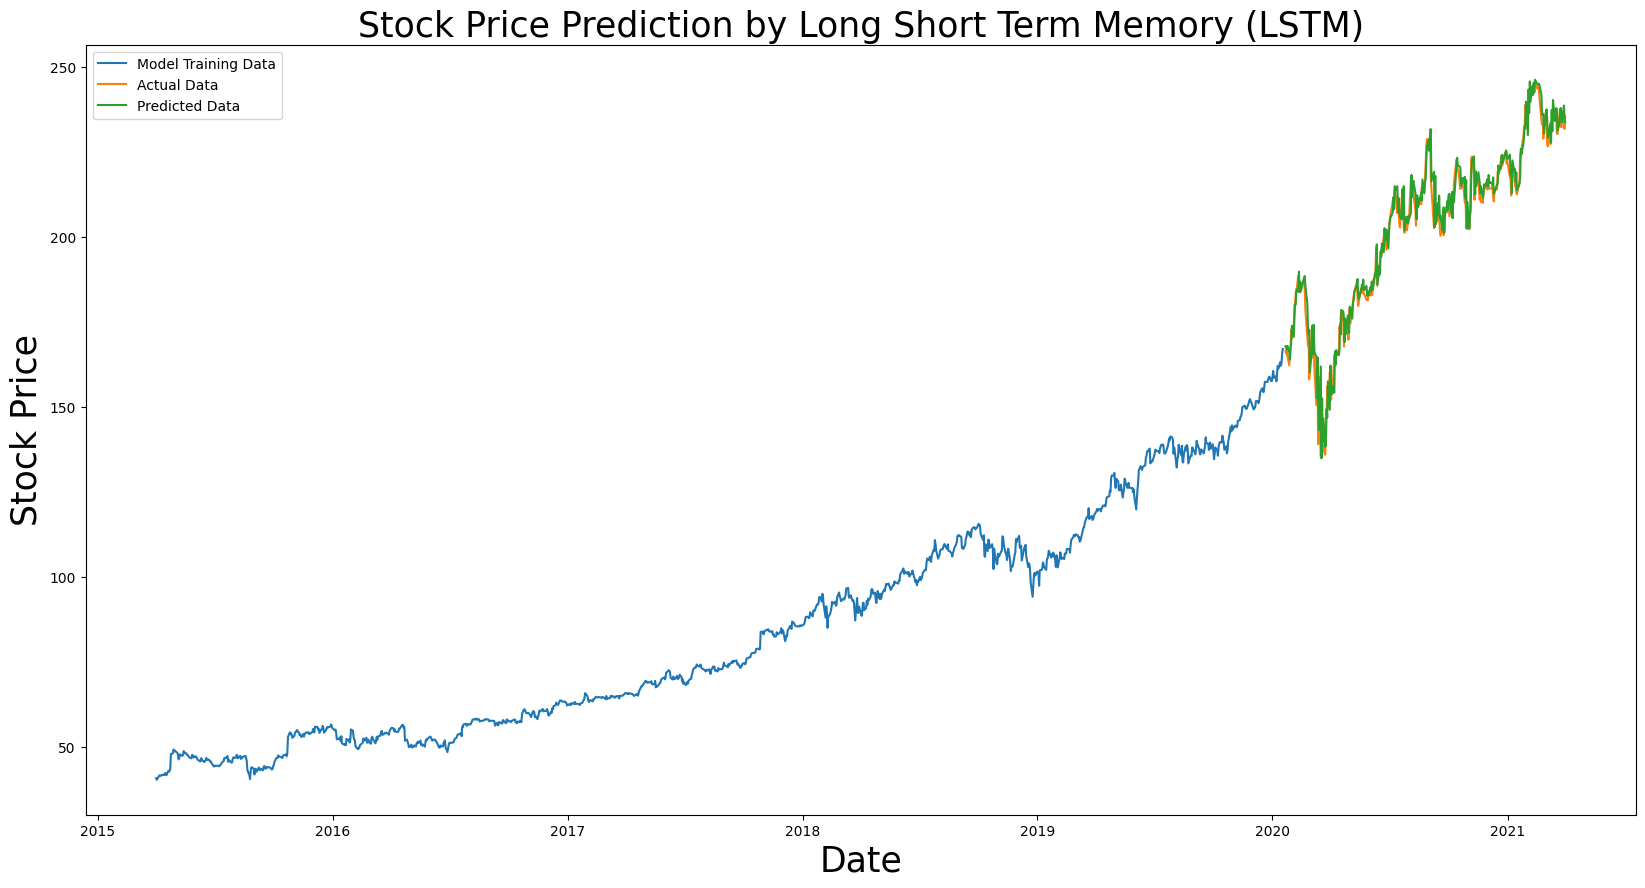

In [7]:

#optimizzer changed to SDG
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='SGD')
    model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=25)
    plt.ylabel('Stock Price',size=25)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=25)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

lstm_prediction(df)